In [1]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add to utils.py: BER vs SNR, improve complex signal handling
- Add timing synchronization
- Add multipath effects to channel & equalizer
- Time offset
- Framing? Detect start of frame


Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add to utils.py: constillation, BER vs SNR, make plotting big signals faster, improve complex signal handling\n- Add carrier recovery and timing synchronization\n- Add multipath effects to channel & equalizer\n- Channel coding: differential coding to deal with phase ambiguity\n- Time offset\n- Framing? Detect start of frame\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [2]:
# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

import importlib
import utils
importlib.reload(utils)
from utils import *


# Constants
SPS = int(2)                        # Large to see pulse shape well
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2) + 1       # qpsk: 2 bits/sample, differential coding: +1 symbol
SNR_DB = 10


/home/cdelong/sdr/sdr_notebooks/utils.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  if show: fig.show()


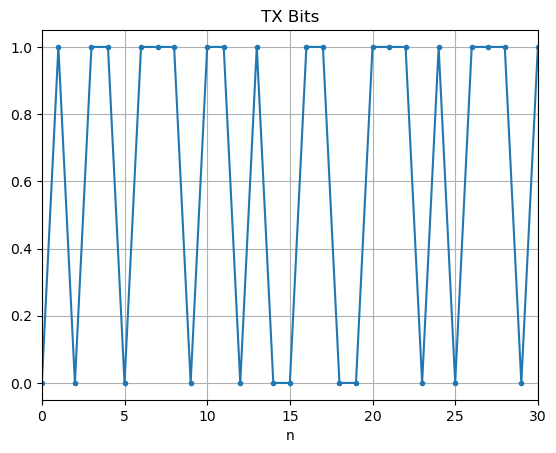

In [3]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
plot_signal(bits_tx, title='TX Bits', xlim=[0, 30])

bit_pairs = bits_tx.reshape(-1, 2)

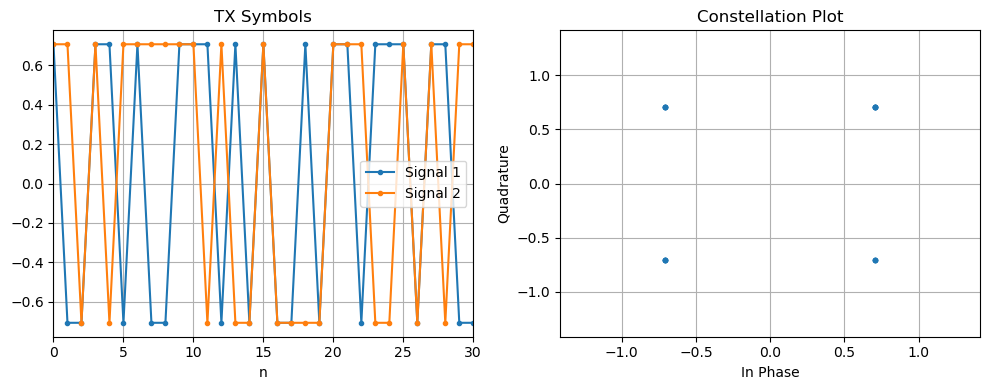

In [4]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
bits_to_sym_map = {
    (0, 0): 1j ** 0,
    (0, 1): 1j ** 1,
    (1, 0): 1j ** 2,
    (1, 1): 1j ** 3,
}

sym_tx = np.array([np.exp(1j*np.pi/4)] + [0]*len(bit_pairs))
for i, pair in enumerate(bit_pairs):
    sym_tx[i+1] = sym_tx[i] * bits_to_sym_map[tuple(pair)]

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_tx.real, sym_tx.imag, title='TX Symbols', xlim=[0, 30], ax=axs[0])
plot_constellation(sym_tx, ax=axs[1])
plt.tight_layout()
plt.show()

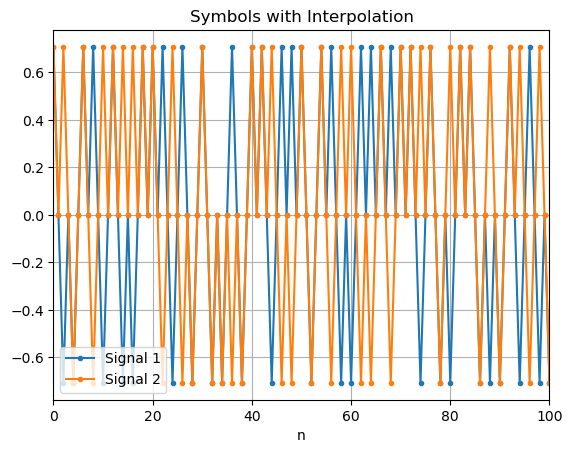

In [5]:
### Pulse filtering ###

# Interpolate by factor of SPS
sym_interp = np.zeros(N_SYMBOLS * SPS, dtype=np.complex128)
for i, sym in enumerate(sym_tx):
    sym_interp[i*SPS] = sym

plot_signal(sym_interp.real, sym_interp.imag, title='Symbols with Interpolation', xlim=[0, 100])


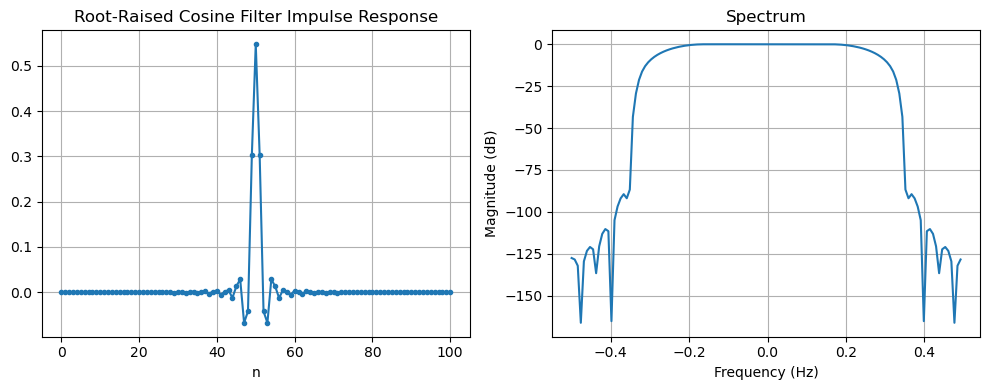

In [6]:
h_rrc = rrc_coef(Ts=SPS)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(h_rrc.real, title='Root-Raised Cosine Filter Impulse Response', ax=axs[0])
plot_spectrum(h_rrc, ax=axs[1])
plt.tight_layout()
plt.show()

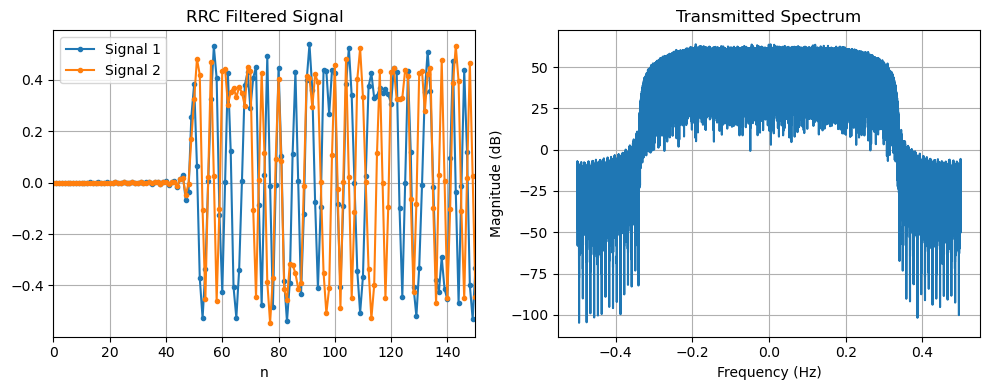

In [7]:
# Convolve signal with RRC filter
sig_tx = np.convolve(sym_interp, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_tx.real, sig_tx.imag, title='RRC Filtered Signal', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_tx, title="Transmitted Spectrum", ax=axs[1])
plt.tight_layout()
plt.show()

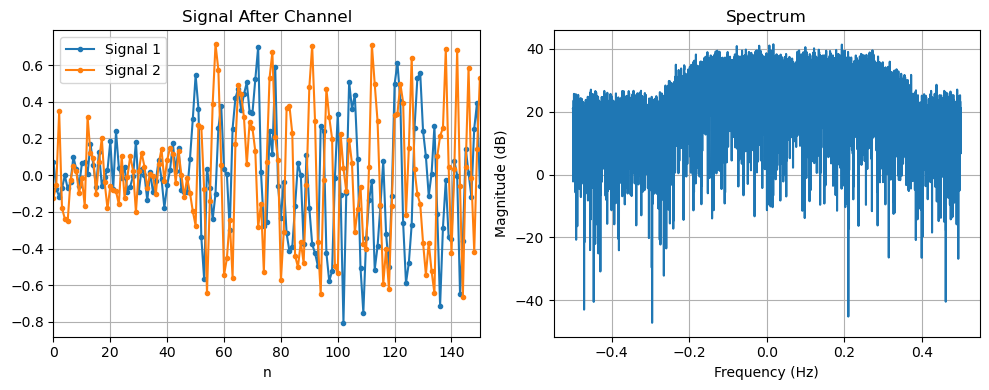

In [8]:
### Channel ###

n = np.arange(len(sig_tx))

# Apply CFO
abs_max_off = 0.1 * (2*np.pi)   # testing/realistic: 1-5%, aggressive: 10%
w_off = 2*abs_max_off*np.random.rand() - abs_max_off  # [radians/sample]
sig_tx = sig_tx * np.exp(1j*w_off*n)

# Apply CPO
p_off = 2*np.pi*np.random.rand()  # [radians]
sig_tx = sig_tx * np.exp(1j*p_off)

# Apply symbol timing offset
t_off = SPS*np.random.rand()


# AWGN
signal_power = np.mean(abs(sig_tx) ** 2)
noise_power = signal_power / (10**(SNR_DB / 10))
awgn = np.sqrt(noise_power / 2) * (np.random.normal(0, 1, len(sig_tx)) + 1j * np.random.normal(0, 1, len(sig_tx)))
sig_rx = sig_tx + awgn

# Visualize signal after channel
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_rx.real, sig_rx.imag, title='Signal After Channel', xlim=[0, 150], ax=axs[0])
plot_spectrum(sig_rx, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()


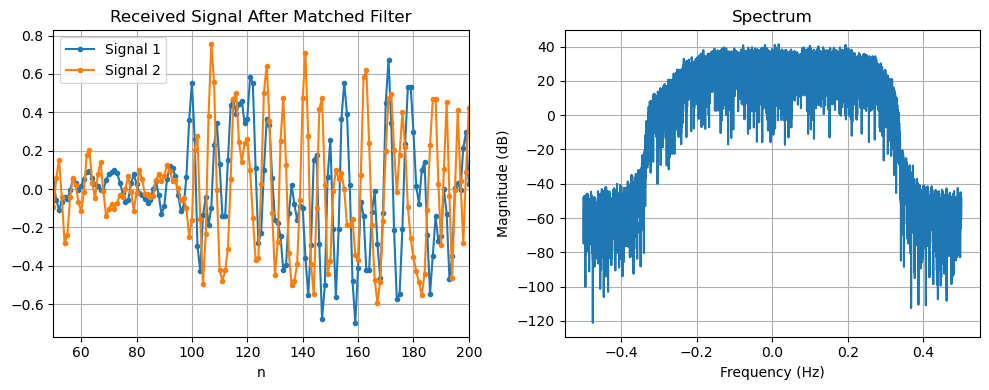

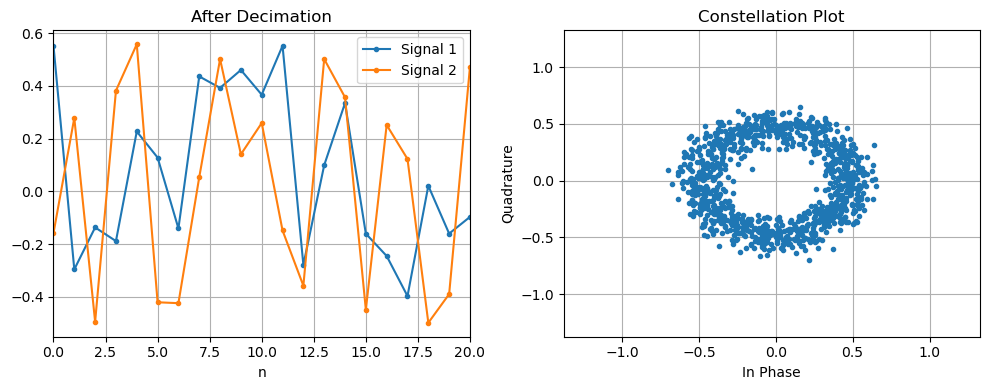

In [9]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_matched.real, sig_matched.imag, xlim=[50, 200], title='Received Signal After Matched Filter', ax=axs[0])
plot_spectrum(sig_matched, n_samples=2**13, ax=axs[1])
plt.tight_layout()
plt.show()

# Remove extra shit from convolutions
sig_matched = sig_matched[100:-100]

# Decimate to 1 sps
sig_dec = np.empty(len(sig_matched) // SPS, dtype=np.complex128)
for i, samp in enumerate(sig_matched):
    if i % SPS == 0:
        sig_dec[i//SPS] = samp

# Plot decimated
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sig_dec.real, sig_dec.imag, title='After Decimation', xlim=[0, 20], ax=axs[0])
plot_constellation(sig_dec, n_samples=1000, ax=axs[1])
plt.tight_layout()
plt.show()

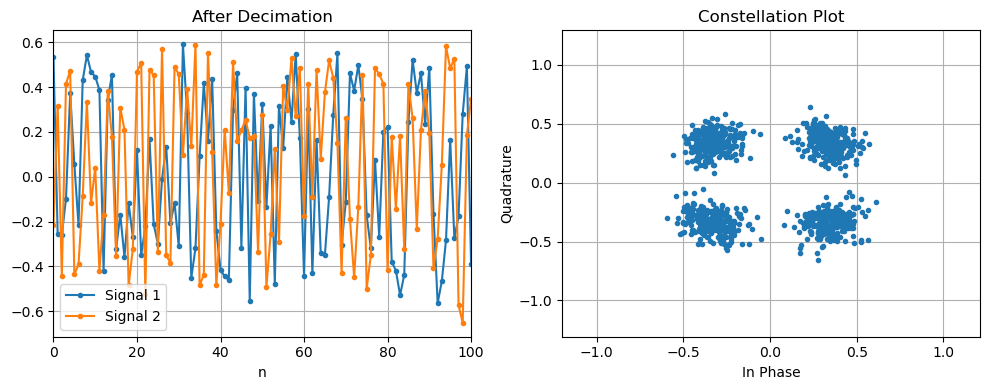

In [12]:
### Symbol Synchronization ###


### 2nd Order Costas Loop ###

# The loop is very slow (~6 seconds) when ran as pure python. Use JIT compilation 
# using numba to speed this up by over an order of magnitude

@njit
def costas_loop(symbols, K_p, K_i, K_f):
    sum_e = 0.0
    theta1 = 0.0
    theta2 = 0.0
    sym_rot = np.empty(len(symbols), dtype=np.complex128)


    for i, s in enumerate(symbols):
        
        ## Stage 1

        # Rotate signal by current VCO phase
        s_rot1 = s * np.exp(-1j * theta1)
        
        # Decision-directed error signal
        I = s_rot1.real
        Q = s_rot1.imag
        ref = np.sign(I) + 1j*np.sign(Q)
        e = np.angle(s_rot1 * np.conj(ref))  # Phase error

        # Update VCO input
        sum_e += K_i*e
        theta1 += K_f*e + sum_e


        ## Stage 2

        # Rotate signal by current VCO phase
        s_rot2 = s * np.exp(-1j * (theta1 + theta2))
        
        # Decision-directed error signal
        I = s_rot2.real
        Q = s_rot2.imag
        ref = np.sign(I) + 1j*np.sign(Q)
        e = np.angle(s_rot2 * np.conj(ref))  # Phase error

        # Update VCO input
        theta2 += K_p*e

        sym_rot[i] = s_rot2
    
    return sym_rot


K_p = 0.01
K_i = 0.1
K_f = 0.1
sym_rot = costas_loop(sig_dec, K_p, K_i, K_f)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_signal(sym_rot.real, sym_rot.imag, title='After Decimation', xlim=[0, 100], ax=axs[0])
plot_constellation(sym_rot[1000:], n_samples=1000, ax=axs[1])
plt.tight_layout()
plt.show()

    

In [11]:
### Demodulation ###

# Make optimum decision for AWGN channel
sym_rx = np.sign(sym_rot.real) + 1j*np.sign(sym_rot.imag)

# Map each symbol to bits
phase_to_bits_map = {
    1j ** 0: (0, 0),
    1j ** 1: (0, 1),
    1j ** 2: (1, 0),
    1j ** 3: (1, 1),
}


bits_rx = np.empty(N_BITS)
for i, sym in enumerate(sym_rx[:-1]):
    dphase = sym_rx[i+1]/sym_rx[i]
    bits_rx[2*i], bits_rx[2*i + 1] = phase_to_bits_map[dphase]

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 0.001589
